# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to instead using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents) according to all patterns of covariation among their features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [394]:
#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.feature_extraction.text
import sklearn.decomposition
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
from matplotlib.colors import ListedColormap
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

%matplotlib inline

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

We also develop a couple of functions for splitting our text data:

In [395]:
def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

# The Naïve Bayes Classifier

## Naive Bayes from Scratch

First, let's build a Naive Bayes classifier from scratch to illustrate what's in a classifier. This example is drawn from *Data Science from Scratch* by Joel Grus. 

### Mathematical Preliminaries

Naïve Bayes contains an independence assumption that the probability of features conditional on classification $S$ is equivalent to the product of conditional probabilities associated with each of those features, hence this model's *naïvité*: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$

To be concrete, let's assume we are building a spam filter. 

Given a vocabulary $w_1,\dots,w_n$, let $X_i$ be the event "message contains" $w_i$." $X_i = x_i, x_i \in \{0,1\}$. 

$S$ is the event "message is spam" and $\neg S$ is the event "message is not spam."

According to Bayes' Theorem: 

$P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n)} = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)\, + \,P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)P(\neg S)}$

We further assume that we have no knowledge of the prior probability of spam; so $P(S) = P(\neg S) = 0.5$ (this is the principle of indifference)

With this simplification, $P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)\, +\, P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)}$ 

Now we make the Naive Bayes assumption: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$
    
We can estimate $P(X_i = x_i\,|\,S)$ by computing the fraction of spam messages containing the word $i$, e.g., Obamacare. 

Smoothing: $P(X_i\,|\,S) = \frac{(k + \textrm{number of spams containing}\, w_i)}{(2k + \textrm{number of spams})}$



## <span style="color:red">*Your thoughts*</span>

<span style="color:red">What will happen if I change my spam threshold from 0.5?

<span style="color:red">What decision rule are we using, when we assign the class label $\hat{y} = S$ when $P(S\,|\,X_1\dots X_n) = \frac{P(S)\prod_i P(X_i = x_i|S)}{P(\textbf{X})} > 0.5$

<span style="color:red">What will happen if we split the data differently (e.g., less training data, more testing data). 

<span style="color:red">**Try it!**

In [396]:
# load email data
def loadEmailDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    # regex for stripping out the leading "Subject:" and any spaces after it
    subject_regex = re.compile(r"^Subject:\s+")
    
    #The dict that will become the DataFrame
    emailDict = {
        'category' : [],
        'text' : [],
    }
    for fPath in filePaths:
        with open(fPath, encoding ='latin1', errors='surrogateescape') as f:
            for line in f:
                if line.startswith("Subject:"):
                    #Could also save the subject field
                    subject = subject_regex.sub("", line).strip()
                    emailDict['text'].append(subject)
    emailDict['category'] = [category] * len(emailDict['text'])
    return pandas.DataFrame(emailDict)

spamDF = loadEmailDir('data/Spam_Data/spam', 'spam')
spamDF = spamDF.append(loadEmailDir('data/Spam_Data/not_spam', 'not spam'), ignore_index= True)
spamDF['is_spam'] = [c == 'spam' for c in spamDF['category']]

In [397]:
# tokenize and normalize
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

spamDF['tokenized_emails'] = spamDF['text'].apply(lambda x: nltk.word_tokenize(x))
spamDF['normalized_emails'] = spamDF['tokenized_emails'].apply(lambda x: normlizeTokens(x, stopwordLst = None, stemmer = None))

In [398]:
# count the number of times each word shows up in spam/ham
def count_words(traingDF, textColumn, trainingColumn):
    counts = collections.defaultdict(lambda: [0, 0])
    for index, row in traingDF.iterrows():
        for word in set(row[textColumn]):
            if row[trainingColumn]:
                counts[word][0] += 1
            else:
                counts[word][1] += 1
    return counts
wordCounts = count_words(spamDF, 'normalized_emails', 'is_spam')

In [399]:
# convert counts into probabilities
def word_probabilities(counts, total_spams, total_non_spams, k=0.5):
    """turn the word_counts into a list of triplets 
    w, p(w | spam) and p(w | ~spam)"""
    retTuples = []
    for w, (spam, non_spam) in counts.items():
        retTuples.append((w,
             (spam + k) / (total_spams + 2 * k),
             (non_spam + k) / (total_non_spams + 2 * k)))
    return retTuples

In [400]:
# compute the spam probability for a message, given word probabilities (using logs) 
def spam_probability(word_probs, message_words):
    #message_words = tokenize(message)
    log_prob_if_spam = log_prob_if_not_spam = 0.0 #Initialize; we are working with log probs to deal with underflow.

    for word, prob_if_spam, prob_if_not_spam in word_probs: #We iterate over all possible words we've observed
        # for each word in the message, 
        # add the log probability of seeing it 
        if word in message_words:
            log_prob_if_spam += math.log(prob_if_spam) #This is prob of seeing word if spam
            log_prob_if_not_spam += math.log(prob_if_not_spam) #This is prob of seeing word if not spam

        # for each word that's not in the message
        # add the log probability of _not_ seeing it
        else:
            log_prob_if_spam += math.log(1.0 - prob_if_spam)
            log_prob_if_not_spam += math.log(1.0 - prob_if_not_spam)
    P = 1/(1 + math.exp(log_prob_if_not_spam - log_prob_if_spam))
    #prob_if_spam = math.exp(log_prob_if_spam) #Compute numerator
    #prob_if_not_spam = math.exp(log_prob_if_not_spam)
    #return prob_if_spam / (prob_if_spam + prob_if_not_spam) #Compute whole thing and return
    return P

Think: how would this change if $P(S) \neq P(\neg S)$

Now we write a class (this is a Python term) for our Naive Bayes Classifier

In [401]:
class NaiveBayesClassifier:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = training_set[trainingColumn].value_counts()[True]
        num_non_spams = len(training_set) - num_spams
        
        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message

In [402]:
# try three different k

# k = 0.3
class NaiveBayesClassifier30:

    def __init__(self, k=0.3):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = training_set[trainingColumn].value_counts()[True]
        num_non_spams = len(training_set) - num_spams
        
        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message

# k = 0.5
class NaiveBayesClassifier50:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = training_set[trainingColumn].value_counts()[True]
        num_non_spams = len(training_set) - num_spams
        
        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message

# k = 0.8
class NaiveBayesClassifier80:

    def __init__(self, k=0.8):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = training_set[trainingColumn].value_counts()[True]
        num_non_spams = len(training_set) - num_spams
        
        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message


To train and then evaluate our model, we will split our data into ***training*** & ***testing*** sets.

In [403]:
np.random.seed(0)
shuffledSpamDF = spamDF.reindex(np.random.permutation(spamDF.index))
holdBackFraction = .2
holdBackIndex = int(holdBackFraction * len(shuffledSpamDF))
train_data = shuffledSpamDF[holdBackIndex:].copy()
test_data = shuffledSpamDF[:holdBackIndex].copy()

In [404]:
classifier30 = NaiveBayesClassifier30()
classifier50 = NaiveBayesClassifier50()
classifier80 = NaiveBayesClassifier80()

In [405]:
classifier30.train(train_data, 'is_spam', 'normalized_emails')
classifier50.train(train_data, 'is_spam', 'normalized_emails')
classifier80.train(train_data, 'is_spam', 'normalized_emails')

Some simple evaluation:

In [406]:
# triplets (subject, actual is_spam, predicted spam probability)
classified30 = [(row['category'], classifier30.classify(row['normalized_emails']))
              for index, row in test_data.iterrows()]
classified50 = [(row['category'], classifier50.classify(row['normalized_emails']))
              for index, row in test_data.iterrows()]
classified80 = [(row['category'], classifier80.classify(row['normalized_emails']))
              for index, row in test_data.iterrows()]

# three thresholds: spam_probability > 0.3, 0.5 and 0.8
counts30 = collections.Counter((actual == 'spam', predicted_probability > 0.3)
                     for actual, predicted_probability in classified30)
counts50 = collections.Counter((actual == 'spam', predicted_probability > 0.5)
                     for actual, predicted_probability in classified50)
counts80 = collections.Counter((actual == 'spam', predicted_probability > 0.8)
                     for actual, predicted_probability in classified80)

In [407]:
print(counts30)
print(counts50)
print(counts80)

Counter({(False, False): 514, (True, True): 80, (False, True): 72, (True, False): 18})
Counter({(False, False): 563, (True, True): 58, (True, False): 40, (False, True): 23})
Counter({(False, False): 578, (True, False): 61, (True, True): 37, (False, True): 8})


Precision, recall and F-measure for different thresholds

In [408]:
# calculate precision: True positives over all positive predictions
precision30 = counts30[(True,True)]/(counts30[(False,True)]+counts30[(True,True)])
precision50 = counts50[(True,True)]/(counts50[(False,True)]+counts50[(True,True)])
precision80 = counts80[(True,True)]/(counts80[(False,True)]+counts80[(True,True)])

print('probability > 0.3:', precision30, '\nprobability > 0.5:', precision50, '\nprobability > 0.8:', precision80)

probability > 0.3: 0.5263157894736842 
probability > 0.5: 0.7160493827160493 
probability > 0.8: 0.8222222222222222


In [409]:
# calculate recall: what fraction of positives identified
recall30 = counts30[(True,True)]/(counts30[(True,False)]+counts30[(True,True)])
recall50 = counts50[(True,True)]/(counts50[(True,False)]+counts50[(True,True)])
recall80 = counts80[(True,True)]/(counts80[(True,False)]+counts80[(True,True)])

print('probability > 0.3:', recall30, '\nprobability > 0.5:', recall50, '\nprobability > 0.8:', recall80)

probability > 0.3: 0.8163265306122449 
probability > 0.5: 0.5918367346938775 
probability > 0.8: 0.37755102040816324


In [410]:
# calculate F-measure
f_measure30 = 2 * (precision30 * recall30)/(precision30 + recall30)
f_measure50 = 2 * (precision50 * recall50)/(precision50 + recall50)
f_measure80 = 2 * (precision80 * recall80)/(precision80 + recall80)
print('probability > 0.3:', f_measure30, '\nprobability > 0.5:', f_measure50, '\nprobability > 0.8:', f_measure80)

probability > 0.3: 0.64 
probability > 0.5: 0.64804469273743 
probability > 0.8: 0.5174825174825174


Let's look at how the emails are classified.

In [411]:
test_data['predicted_spam_probability30'] = [classifier30.classify(d) for d in test_data['normalized_emails']]
test_data['predicted_spam_probability50'] = [classifier50.classify(d) for d in test_data['normalized_emails']]
test_data['predicted_spam_probability80'] = [classifier80.classify(d) for d in test_data['normalized_emails']]

In [412]:
test_data[:5]

,category,text,is_spam,tokenized_emails,normalized_emails,predicted_spam_probability30,predicted_spam_probability50,predicted_spam_probability80
927,not spam,Re: http://apt.nixia.no/,False,"[Re, :, http, :, //apt.nixia.no/]","[re, http]",0.001476,0.000608,0.000120
182,spam,"Testing a system, please delete",True,"[Testing, a, system, ,, please, delete]","[testing, a, system, please, delete]",0.005734,0.003957,0.001259
33,spam,EIN News - FREE Trial,True,"[EIN, News, -, FREE, Trial]","[ein, news, free, trial]",0.905427,0.712997,0.247044
1473,not spam,Re: Secure Sofware Key,False,"[Re, :, Secure, Sofware, Key]","[re, secure, sofware, key]",0.000040,0.000044,0.000021
981,not spam,Re: bad focus/click behaviours,False,"[Re, :, bad, focus/click, behaviours]","[re, bad, behaviours]",0.000128,0.000087,0.000027


Now, we calculate the ROC curve, and integrate to get the area under the curve (AUC), or probability mass associated with correct classification.

In [413]:
x30, y30, _ = sklearn.metrics.roc_curve(test_data['is_spam'], test_data['predicted_spam_probability30'])
roc_auc30 = sklearn.metrics.auc(x30,y30)
x50, y50, _ = sklearn.metrics.roc_curve(test_data['is_spam'], test_data['predicted_spam_probability50'])
roc_auc50 = sklearn.metrics.auc(x50,y50)
x80, y80, _ = sklearn.metrics.roc_curve(test_data['is_spam'], test_data['predicted_spam_probability80'])
roc_auc80 = sklearn.metrics.auc(x80,y80)

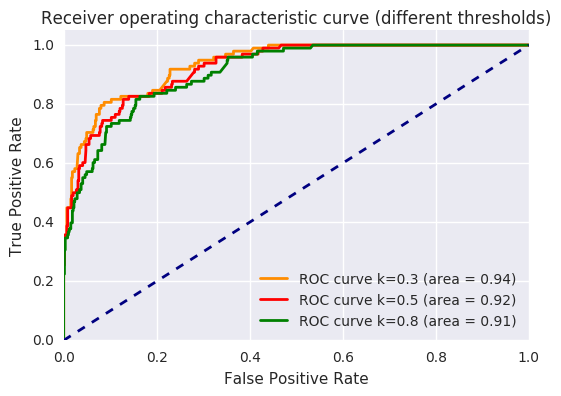

In [414]:
plt.figure()
plt.plot(x30, y30, color = 'darkorange', lw = 2, label='ROC curve k=0.3 (area = %0.2f)' % roc_auc30)
plt.plot(x50, y50, color = 'red', lw = 2, label='ROC curve k=0.5 (area = %0.2f)' % roc_auc50)
plt.plot(x80, y80, color = 'green', lw = 2, label='ROC curve k=0.8 (area = %0.2f)' % roc_auc80)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve (different thresholds)')
plt.legend(loc="lower right")
plt.show()

In [415]:
# trying different train/test sets
np.random.seed(0)
shuffledSpamDF = spamDF.reindex(np.random.permutation(spamDF.index))

# hold .4 of data as the test set
holdBackFraction2 = .05
holdBackIndex2 = int(holdBackFraction2 * len(shuffledSpamDF))
train_data2 = shuffledSpamDF[holdBackIndex2:].copy()
test_data2 = shuffledSpamDF[:holdBackIndex2].copy()

# hold .5 of data as the test set
holdBackFraction3 = .5
holdBackIndex3 = int(holdBackFraction3 * len(shuffledSpamDF))
train_data3 = shuffledSpamDF[holdBackIndex3:].copy()
test_data3 = shuffledSpamDF[:holdBackIndex3].copy()

In [416]:
classifier50.train(train_data2, 'is_spam', 'normalized_emails')
classifier50.train(train_data3, 'is_spam', 'normalized_emails')

In [417]:
# triplets (subject, actual is_spam, predicted spam probability)
classified50_2 = [(row['category'], classifier50.classify(row['normalized_emails']))
              for index, row in test_data2.iterrows()]
classified50_3 = [(row['category'], classifier50.classify(row['normalized_emails']))
              for index, row in test_data3.iterrows()]

# two other different train/test with spam_probability > 0.5
counts50_2 = collections.Counter((actual == 'spam', predicted_probability > 0.5)
                     for actual, predicted_probability in classified50_2)
counts50_3 = collections.Counter((actual == 'spam', predicted_probability > 0.5)
                     for actual, predicted_probability in classified50_3)

In [418]:
test_data2['predicted_spam_probability50'] = [classifier50.classify(d) for d in test_data2['normalized_emails']]
test_data3['predicted_spam_probability50'] = [classifier50.classify(d) for d in test_data3['normalized_emails']]

In [419]:
x50_2, y50_2, _ = sklearn.metrics.roc_curve(test_data2['is_spam'], test_data2['predicted_spam_probability50'])
roc_auc50_2 = sklearn.metrics.auc(x50_2,y50_2)
x50_3, y50_3, _ = sklearn.metrics.roc_curve(test_data3['is_spam'], test_data3['predicted_spam_probability50'])
roc_auc50_3 = sklearn.metrics.auc(x50_3,y50_3)

In [420]:
# calculate precision: True positives over all positive predictions
precision50_2 = counts50_2[(True,True)]/(counts50_2[(False,True)]+counts50_2[(True,True)])
precision50_3 = counts50_3[(True,True)]/(counts50_3[(False,True)]+counts50_3[(True,True)])

# calculate recall: what fraction of positives identified
recall50_2 = counts50_2[(True,True)]/(counts50_2[(True,False)]+counts50_2[(True,True)])
recall50_3 = counts50_3[(True,True)]/(counts50_3[(True,False)]+counts50_3[(True,True)])

# calcualte F-measure
f_measure50_2 = 2 * (precision50_2 * recall50_2)/(precision50_2 + recall50_2)
f_measure50_3 = 2 * (precision50_3 * recall50_3)/(precision50_3 + recall50_3)

print('Compare precision')
print('test set fraction = 0.2:', precision50, '\ntest set fraction = 0.05:', precision50_2, '\ntest set fraction= 0.5:', precision50_3)
print('Comprea recall')
print('test set fraction = 0.2:', recall50, '\ntest set fraction = 0.05:', recall50_2, '\ntest set fraction= 0.5:', recall50_3)
print('Compare F-measure')
print('test set fraction = 0.2:', f_measure50, '\ntest set fraction = 0.05:', f_measure50_2, '\ntest set fraction= 0.5:', f_measure50_3)

Compare precision
test set fraction = 0.2: 0.7160493827160493 
test set fraction = 0.05: 0.6666666666666666 
test set fraction= 0.5: 0.732620320855615
Comprea recall
test set fraction = 0.2: 0.5918367346938775 
test set fraction = 0.05: 0.4444444444444444 
test set fraction= 0.5: 0.5436507936507936
Compare F-measure
test set fraction = 0.2: 0.64804469273743 
test set fraction = 0.05: 0.5333333333333333 
test set fraction= 0.5: 0.6241457858769931


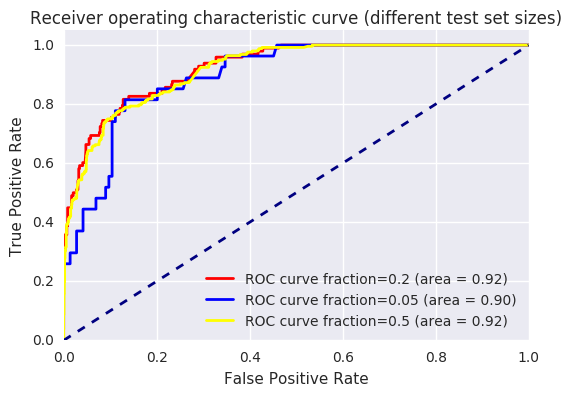

In [421]:
plt.figure()
plt.plot(x50, y50, color = 'red', lw = 2, label='ROC curve fraction=0.2 (area = %0.2f)' % roc_auc50)
plt.plot(x50_2, y50_2, color = 'blue', lw = 2, label='ROC curve fraction=0.05 (area = %0.2f)' % roc_auc50_2)
plt.plot(x50_3, y50_3, color = 'yellow', lw = 2, label='ROC curve fraction=0.5 (area = %0.2f)' % roc_auc50_3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve (different test set sizes)')
plt.legend(loc="lower right")
plt.show()

We can also find words that lead to a high probability of spam (using Bayes' Theorem):

In [422]:
def p_spam_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_spam, prob_if_not_spam = word_prob
    return prob_if_spam / (prob_if_spam + prob_if_not_spam)

In [423]:
words = sorted(classifier50.word_probs,key=p_spam_given_word)

In [424]:
spammiest_words = words[-15:]
hammiest_words = words[:15]

In [425]:
spammiest_words

[('sale', 0.017857142857142856, 0.00034199726402188782),
 ('extended', 0.021825396825396824, 0.00034199726402188782),
 ('auto', 0.021825396825396824, 0.00034199726402188782),
 ('per', 0.021825396825396824, 0.00034199726402188782),
 ('warranties', 0.021825396825396824, 0.00034199726402188782),
 ('need', 0.025793650793650792, 0.00034199726402188782),
 ('norton', 0.025793650793650792, 0.00034199726402188782),
 ('clearance', 0.02976190476190476, 0.00034199726402188782),
 ('mortgage', 0.02976190476190476, 0.00034199726402188782),
 ('b', 0.02976190476190476, 0.00034199726402188782),
 ('zzzz', 0.037698412698412696, 0.00034199726402188782),
 ('money', 0.037698412698412696, 0.00034199726402188782),
 ('systemworks', 0.041666666666666664, 0.00034199726402188782),
 ('rates', 0.0496031746031746, 0.00034199726402188782),
 ('adv', 0.057539682539682536, 0.00034199726402188782)]

In [426]:
hammiest_words

[('spambayes', 0.001984126984126984, 0.040697674418604654),
 ('use', 0.001984126984126984, 0.035225718194254449),
 ('zzzzteana', 0.001984126984126984, 0.033857729138166898),
 ('sadev', 0.001984126984126984, 0.027017783857729138),
 ('ouch', 0.001984126984126984, 0.024965800273597811),
 ('perl', 0.001984126984126984, 0.024281805745554035),
 ('selling', 0.001984126984126984, 0.022229822161422708),
 ('bliss', 0.001984126984126984, 0.022229822161422708),
 ('wedded', 0.001984126984126984, 0.022229822161422708),
 ('java', 0.001984126984126984, 0.01880984952120383),
 ('satalk', 0.0059523809523809521, 0.051641586867305064),
 ('kiddies', 0.001984126984126984, 0.016757865937072503),
 ('problem', 0.001984126984126984, 0.015389876880984952),
 ('apt', 0.001984126984126984, 0.014705882352941176),
 ('headlines', 0.001984126984126984, 0.014705882352941176)]

# My Memo

The Naive Bayse classifier is using maximum likelihood estiamtion to classify data.
  
I have tried three different thresholds k for classifying spam/ham: 0.3, 0.5 and 0.8. Different p results in different precision, recall and F-measure values. k=0.8 has the highest precision and k=0.3 has the highest recall. Overall, however, k=0.5 (original) has the highest F-measure value although only slightly higher than that of k=0.3. The ROC curves suggest that the model with k=0.3 has the best performance among all.
  
I have tried three different test set size for classifying spam/ham: 0.05, 0.2 and 0.5. Different test set size results in different precision, recall and F-measure values. The test size=0.5 has the highest precision and the test size=0.2 (original) has the highest recall and F-measure values. The ROC curves suggest that the model with the test set size of 0.05 has the worst performance among all, implying overfitting.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.

# My corpus: The Guardian articles with two different serach terms

My corpus consists of The Guardian articles in 2016 for two differnet search terms: automation and immigration. These articles are collected using the API query for each search term. Without overlapping articles, there are total 995 articles in this corpus wherein 498 articles are labeled 'automation' and 497 articles are labeled 'immigration'.

In [427]:
# import data
automationDF = pandas.read_pickle('guardian_automation.pkl')
immigrationDF = pandas.read_pickle('guardian_immigration.pkl')

In [428]:
# remove overlapping articles to simplify
bothDF = pandas.merge(automationDF, immigrationDF, how='inner', on=['url'])
automationDF = automationDF[-automationDF.url.isin(bothDF.url)]
immigrationDF = immigrationDF[-immigrationDF.url.isin(bothDF.url)]
# add keywords
automationDF['keyword'] = 'automation'
immigrationDF['keyword'] = 'immigration'
# concatenate
guardianDF = pandas.concat([automationDF, immigrationDF], ignore_index=True)
# get normalized tokens
guardianDF['normalized_text'] = guardianDF['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

In [429]:
# turn keywords into a binary variable
guardianDF['IsAutomation'] = [s == 'automation' for s in guardianDF['keyword']]

In [430]:
np.random.seed(0)
guardianDF = guardianDF.reindex(np.random.permutation(guardianDF.index))
holdBackFraction = .25
holdBackIndex = int(holdBackFraction * len(guardianDF))
train_data = guardianDF[holdBackIndex:].copy()
test_data = guardianDF[:holdBackIndex].copy()

In [431]:
print (len(train_data))
print (len(test_data))

747
248


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix:

In [432]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [433]:
TFVects.shape

(747, 14101)

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization but rather classification and so all principal components are calculated.

In [434]:
PCA = sklearn.decomposition.PCA
pca = PCA().fit(TFVects.toarray())
reduced_data = pca.transform(TFVects.toarray())

Visualization in 2D:

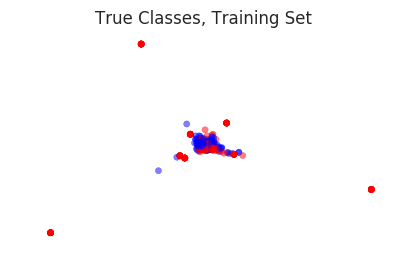

In [435]:
colordict = {
True: 'red',
False: 'blue',
    }
colors = [colordict[c] for c in train_data['IsAutomation']]
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish 'automation' from 'immigration' very well. Let's perform a screeplot to see how many dimensions we need.

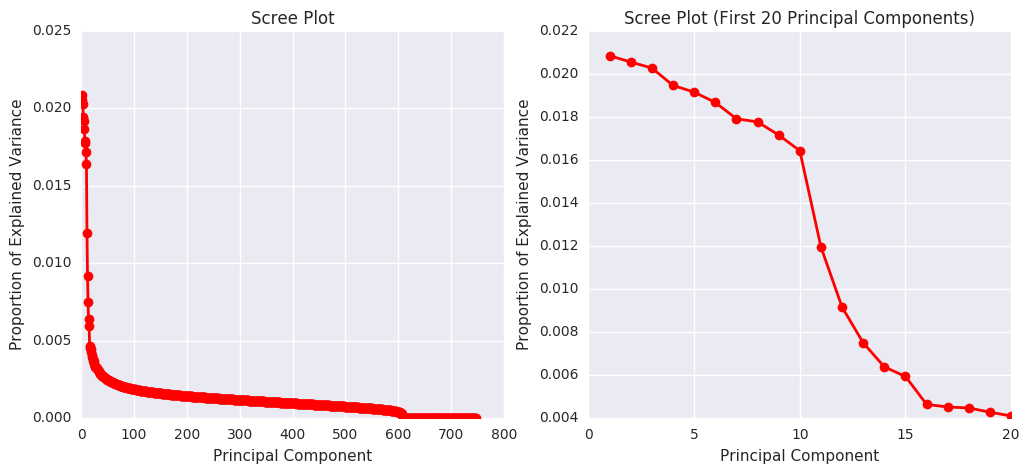

In [436]:
n = TFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [437]:
X = reduced_data[:, :10]

Transform our predictor variable. 

In [438]:
Y = np.array([int(label) for label in train_data['IsAutomation']])

Now we fit a logistic regression to our data.

In [439]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset on we develop the model. Unfortunately, mean accuracy is only about 68%.

In [440]:
logistic.score(X,Y)

0.69611780455153949

How does it perform on the testing dataset, which we "held out" and did not use for model training?

In [441]:
TFVects_test = TFVectorizer.transform(test_data['text'])
reduced_data_test = pca.transform(TFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in test_data['IsAutomation']])
logistic.score(X_test, Y_test)

0.72580645161290325

Slightly better?? How about using more dimensions (40)?

In [442]:
X = reduced_data[:, :40]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :40]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.94109772423
0.939516129032


Or still more (100)?

In [443]:
X = reduced_data[:, :100]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :100]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.95983935743
0.947580645161


Or even more (200)!

In [444]:
X = reduced_data[:, :200]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :200]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.974564926372
0.943548387097


This is becoming ridiculous (400)!

In [445]:
X = reduced_data[:, :400]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :400]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.989290495315
0.939516129032


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 94%. I can also try a logistic regression that uses L1 regularization or the L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [446]:
X = TFVects
logistic_l1= linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(X, Y)
print(logistic_l1.score(X,Y))

0.903614457831


Train the model using training data, and then test it on the testing data.

In [447]:
print(logistic_l1.score(TFVects_test,Y_test))

0.883064516129


94.7% accuracy with 100 pricipal components seems like the best we can get by using a logistic regression.

## Naive Bayes

In [448]:
#wc = wordCounts(train_data, 'normalized_text')
wc = count_words(train_data, 'normalized_text', 'IsAutomation')
wc['robot']

[131, 2]

In [449]:
classifier = NaiveBayesClassifier()
classifier.train(train_data, 'IsAutomation', 'normalized_text')

Let's evaluate the result on the test data.

In [450]:
classified = []
for index, row in test_data.iterrows():
    classified.append((row['normalized_text'], row['IsAutomation'], classifier.classify(row['normalized_text'])))

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = collections.Counter((actual, predicted_probability > 0.5)
                     for text, actual, predicted_probability in classified)

counts

Counter({(False, False): 132,
         (False, True): 2,
         (True, False): 29,
         (True, True): 85})

Precision, recall and F measure

In [451]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
f_measure = 2 * (precision * recall)/(precision + recall)
print('precision:', precision)
print('recall:', recall)
print ('F measure', f_measure)

precision: 0.9770114942528736
recall: 0.7456140350877193
F measure 0.8457711442786069


In [452]:
df_classification = pandas.DataFrame(classified, columns = ['guardian article', 'is automation', 'posterior probability'])
df_classification = df_classification.round(2)

Let's take a look at how well our posterior distribution looks relative to the truth.

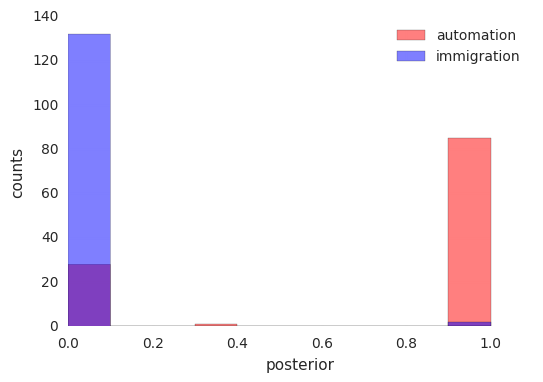

In [453]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(False)
ax1.set_frame_on(False)
df_classification[df_classification['is automation'] == True]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'automation', color = 'red')
df_classification[df_classification['is automation'] == False]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'immigration', color = 'blue')
ax1.set_xlim((0,1.1))
ax1.legend()
ax1.set_xlabel('posterior')
ax1.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate.

In [454]:
def p_automation_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_automation, prob_if_not_automation = word_prob
    return prob_if_automation / (prob_if_automation + prob_if_not_automation)

In [455]:
words = sorted(classifier.word_probs,key=p_automation_given_word)

In [456]:
automation_words = words[-10:]
immigration_words = words[:10]

What are the words that distinguish automation and immigration articles?

In [457]:
automation_words

[('tidi', 0.081818181818181818, 0.0013736263736263737),
 ('driverless', 0.084415584415584416, 0.0013736263736263737),
 ('bike', 0.092207792207792211, 0.0013736263736263737),
 ('wireless', 0.092207792207792211, 0.0013736263736263737),
 ('mode', 0.10519480519480519, 0.0013736263736263737),
 ('autonom', 0.10779220779220779, 0.0013736263736263737),
 ('bend', 0.12077922077922078, 0.0013736263736263737),
 ('entrepreneur', 0.12337662337662338, 0.0013736263736263737),
 ('artifici', 0.14675324675324675, 0.0013736263736263737),
 ('autom', 0.73896103896103893, 0.006868131868131868)]

In [458]:
immigration_words

[('detaine', 0.0012987012987012987, 0.11675824175824176),
 ('nauru', 0.0012987012987012987, 0.11675824175824176),
 ('resettl', 0.0012987012987012987, 0.083791208791208785),
 ('manus', 0.0012987012987012987, 0.075549450549450545),
 ('hardlin', 0.0012987012987012987, 0.064560439560439567),
 ('asylum', 0.0064935064935064939, 0.25137362637362637),
 ('detain', 0.0038961038961038961, 0.14423076923076922),
 ('detent', 0.0064935064935064939, 0.23214285714285715),
 ('adequ', 0.0012987012987012987, 0.045329670329670328),
 ('fled', 0.0012987012987012987, 0.045329670329670328)]

## Multinomial Naive Bayes with an augmented corpus, now including another set of articles with search term = globalization

In [459]:
# import data
automationDF = pandas.read_pickle('guardian_automation.pkl')
immigrationDF = pandas.read_pickle('guardian_immigration.pkl')
globalizationDF = pandas.read_pickle('guardian_globalization.pkl')

In [460]:
# remove overlapping articles to simplify
overlap1_DF = pandas.merge(automationDF, immigrationDF, how='inner', on=['url'])
overlap2_DF = pandas.merge(automationDF, globalizationDF, how='inner', on=['url'])
overlap3_DF = pandas.merge(immigrationDF, globalizationDF, how='inner', on=['url'])

for i in [overlap1_DF.url, overlap2_DF.url]:
    automationDF = automationDF[-automationDF.url.isin(i)]
for i in [overlap1_DF.url, overlap3_DF.url]:
    immgrationDF = immigrationDF[-immigrationDF.url.isin(i)]
for i in [overlap2_DF.url, overlap3_DF.url]:
    globalizationDF = globalizationDF[-globalizationDF.url.isin(i)]

# add keywords
automationDF['keyword'] = 'automation'
immigrationDF['keyword'] = 'immigration'
globalizationDF['keyword'] = 'globalization'

# concatenate
guardianDF2 = pandas.concat([automationDF, immigrationDF, globalizationDF], ignore_index=True)

# get normalized tokens
guardianDF2['normalized_text'] = guardianDF2['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Let's split the data into training data and test data.

In [461]:
data = list(zip(guardianDF2['text'], guardianDF2['keyword']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

In [462]:
print (len(train_data))
print (len(test_data))

1109
379


In [463]:
train_text = [data[0] for data in train_data]
train_target = [data[1] for data in train_data]
test_text = [data[0] for data in test_data]
test_target = [data[1] for data in test_data]

In [464]:
model = make_pipeline(TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2'), MultinomialNB()) #This applies the vectorizer, then trains Multinomial NB
model.fit(train_text,train_target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [465]:
labels = model.predict(test_text)

In [466]:
labels.size

379

In [467]:
model.classes_

array(['automation', 'globalization', 'immigration'], 
      dtype='<U13')

Confusion matrix:

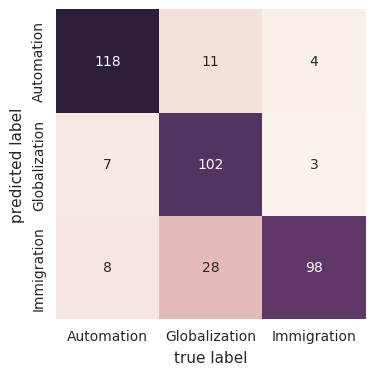

In [468]:
mat = confusion_matrix(test_target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Automation', 'Globalization', 'Immigration'],
                yticklabels=['Automation', 'Globalization', 'Immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [469]:
print('prediction:',sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:',sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

prediction: 0.852775089873
recall: 0.839050131926
F measure: 0.838523710331


In order to get the ROC curves, first we need to binarize the labels.

In [470]:
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
print(lb.classes_)
print(lb.transform(['Globalization', 'Automation']))

['automation' 'globalization' 'immigration']
[[0 0 0]
 [0 0 0]]


In [471]:
y_test = lb.transform(test_target)
y_score = model.predict_proba(test_text)

In [472]:
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

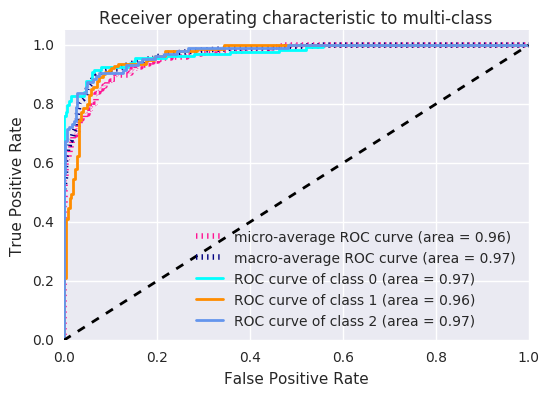

In [473]:
lw = 2
n_classes = 3
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method assign it to a category. This extrapolation to new, untagged data will likely be the main point of a social science application.

In [474]:
model.predict(['innovate'])

array(['automation'], 
      dtype='<U13')

In [475]:
model.predict(['corporation'])

array(['automation'], 
      dtype='<U13')

In [476]:
model.predict(['Chicago'])

array(['immigration'], 
      dtype='<U13')

## My Memo

For logistic regression and naive Bayes classifiers, I used the corpus consisting of Guardian articles I collected using the following two keywords: 'automation', 'immigration'. Using logistic regression as a classifier, I was able to achieve 94.7% accuracy with 100 principal components. This is higher than another logistic regression classifier with L1 regulaization, which shows about 88% accuracy. With Naive Bayes classifier, precision is 0.977, recall is and F measure is .

Then, for I agumented the corpus by adding Guardian articles I collected using the the keyword: 'globalization'. The multinomial naive Bayes classifier achieves precision of 0.853, recall of 0.839, and F measure of 0.839. The AUC is 0.97, which is good.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with the last ***your turn***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

# Decision Trees

We now return to the python Machine learning package, Scikit-Learn, for a decision tree example. Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

## Let's try this on the Automation / Globalization / Immigration dataset.

In [477]:
def visualize_classifier(model, X, y, Xmod, ymod, ax=None, cmap='rainbow'): #X and y are plotted; Xmod and ymod train
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(Xmod, ymod)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

In [478]:
tree = DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [479]:
TFVects = TFVectorizer.fit_transform(train_text)

In [480]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(TFVects,train_target)

In [481]:
TFVects_test = TFVectorizer.transform(test_text)

In [482]:
labels = tree.predict(TFVects_test)

Confusion matrix:

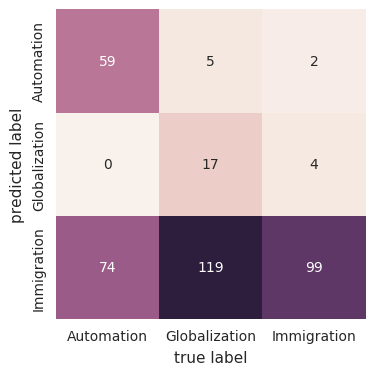

In [483]:
mat = confusion_matrix(test_target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Automation', 'Globalization', 'Immigration'],
                yticklabels=['Automation', 'Globalization', 'Immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [484]:
print('precision:', sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

precision: 0.708802405291
recall: 0.461741424802
F measure: 0.424339504979


AUC of the macro ROC curve

In [485]:
# binarize
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
y_test = lb.transform(test_target)
y_score = tree.predict_proba(TFVects_test)

# Compute ROC curve and ROC area for each class
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])
print('auc:', roc_auc["macro"])

auc: 0.722091013422


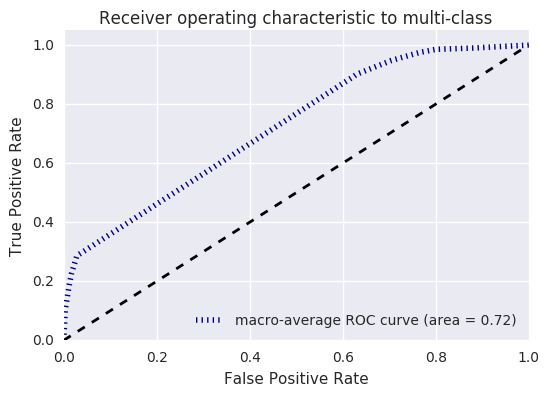

In [486]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

The decision tree is noticeably poorer than Multinomial Naive Bayes. Let's try a random forest.

In [487]:
bag.fit(TFVects,train_target) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [488]:
labels = bag.predict(TFVects_test)

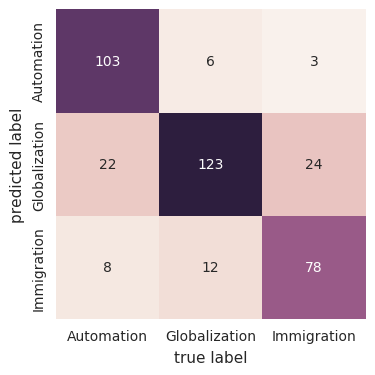

In [489]:
mat = confusion_matrix(test_target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Automation', 'Globalization', 'Immigration'],
                yticklabels=['Automation', 'Globalization', 'Immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [490]:
print('precision:', sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

precision: 0.813997969252
recall: 0.802110817942
F measure: 0.80318878412


In [491]:
# binarize
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
y_test = lb.transform(test_target)
y_score = bag.predict_proba(TFVects_test)

# Compute ROC curve and ROC area for each class
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])
print('auc:', roc_auc["macro"])

auc: 0.936959914675


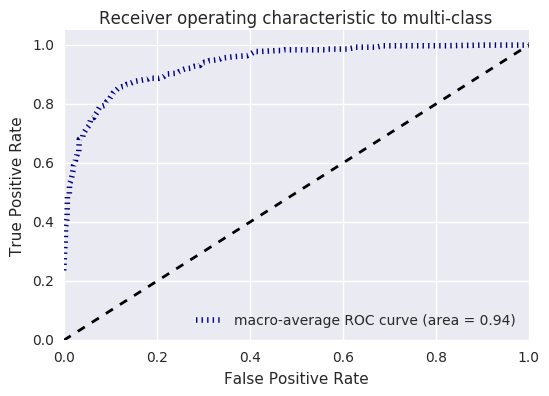

In [492]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

The performance is *significantly* better!

In [493]:
# visualize_classifier(bag, TFVects_test, train_data, TFVects, train_target)

# My Memo

Here I used the same corpus consisting of Guardian articles I collected using the following three keywords: 'automation', 'globalization', 'immigration'. The heatmaps suggest that the single decision tree is a horrible classifier. It fails to correctly classfy almost all articles for 'automation' and 'globaliztion.' Indeed its precision, recall, and F-measure scores are: 0.709, 0.462, 0.424, and 0.722. The random forest classifier by bagging trees shows much improved performance. It correctly classifies the majority of articles for each keyword. The precision, recall, F-measure, and AUC are: 0.814, 0.802, 0.803, and 0.937.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in week 3?

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the labeled datapoint in question and "borrow" its label.

In [494]:
data = list(zip(guardianDF2['text'], guardianDF2['keyword']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

train_text = [data[0] for data in train_data]
train_target = [data[1] for data in train_data]
test_text = [data[0] for data in test_data]
test_target = [data[1] for data in test_data]

Let's visualize it using PCA.

In [495]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_text)

In [496]:
TFVects.shape

(1109, 14118)

In [497]:
reduced_data = PCA(n_components = 2).fit_transform(TFVects.toarray())

Visualization:

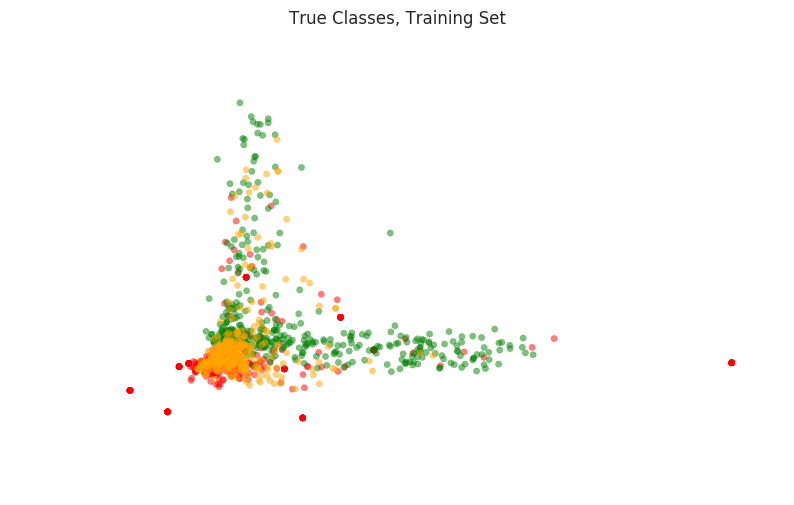

In [498]:
colordict = {
'automation': 'red',
'globalization': 'orange',
'immigration': 'green',
    }
colors = [colordict[c] for c in train_target]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

Let's initialize our k-nearest neighbors classifier.

In [560]:
n_neighbors = 15
weights="uniform"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

For visualization purpopose, let's first try applying the k-nearest neighbors classifier to the projected data.

In [561]:
clf.fit(reduced_data, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [562]:
TFVects_test = TFVectorizer.transform(test_text)
reduced_data_test = PCA(n_components = 2).fit_transform(TFVects_test.toarray())

In [563]:
labels = clf.predict(reduced_data_test)

Confusion matrix:

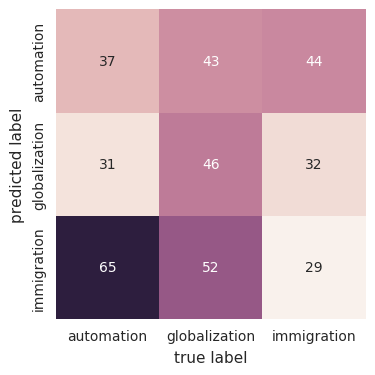

In [564]:
mat = confusion_matrix(test_target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['automation','globalization','immigration'],
                yticklabels=['automation','globalization','immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [565]:
print('precision:', sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

precision: 0.31674468446
recall: 0.295514511873
F measure: 0.3019701004


AUC of the ROC curve

In [566]:
# binarize
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
y_test = lb.transform(test_target)
y_score = clf.predict_proba(reduced_data_test)

# Compute ROC curve and ROC area for each class
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])
print('auc:', roc_auc["macro"])

auc: 0.465430689413


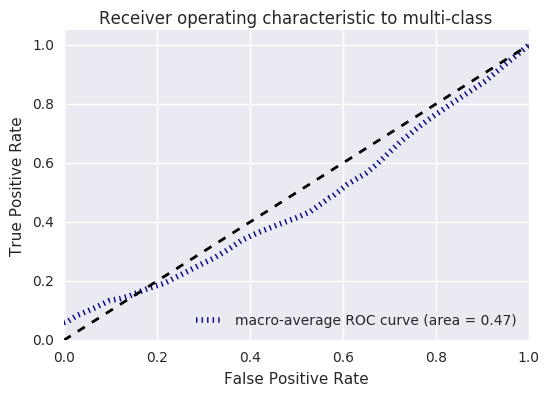

In [567]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

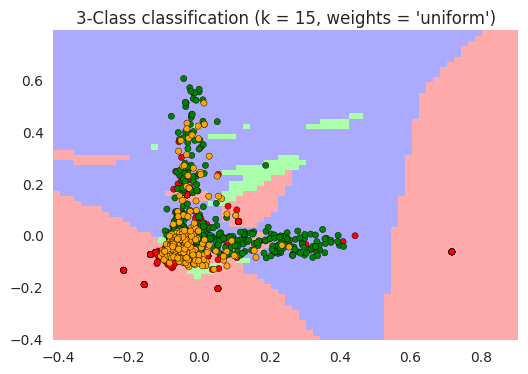

In [568]:
h = .02  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = reduced_data[:, 0].min() - 0.2, reduced_data[:, 0].max() + 0.2
y_min, y_max = reduced_data[:, 1].min() - 0.2, reduced_data[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Znum = []
for i in Z:
    if i == 'automation':
        Znum.append(0)
    elif i == 'globalization':
        Znum.append(1)
    elif i == 'immigration':
        Znum.append(2)
Znum = np.array(Znum).reshape(xx.shape)

# Put the result into a color plot
plt.figure()
plt.pcolormesh(xx, yy, Znum, cmap=cmap_light)

# Plot also the training points
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

plt.show()

In [571]:
print(xx.ravel().shape, yy.ravel().shape)

(4087,) (4087,)


Let's use the full tf-idf matrix instead.

In [594]:
clf.fit(TFVects, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [595]:
labels = clf.predict(TFVects_test)

Confusion matrix:

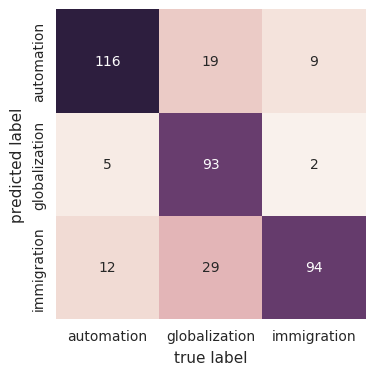

In [596]:
mat = confusion_matrix(test_target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['automation','globalization','immigration'],
                yticklabels=['automation','globalization','immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Small improvement. In this case, PCA reduced the dimensionality of the data without loosing too much informatin.
Finally, let's use it again on the Guardian articles dataset.

In [597]:
print('precision:', sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F-measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

precision: 0.821583113456
recall: 0.799472295515
F-measure: 0.798060893321


AUC of the ROC curve

In [598]:
# binarize
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
y_test = lb.transform(test_target)
y_score = clf.predict_proba(TFVects_test)

# Compute ROC curve and ROC area for each class
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])
print('auc:', roc_auc["macro"])

auc: 0.946604802271


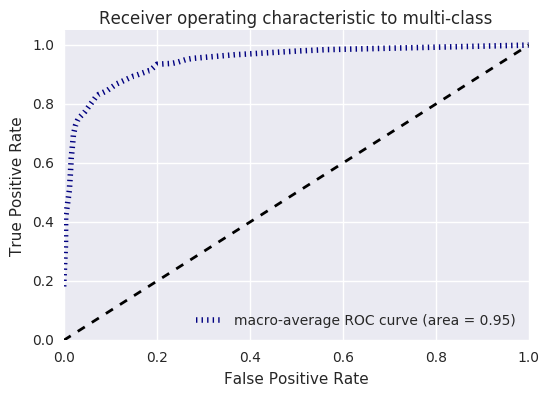

In [599]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# My Memo

Here I used the same corpus consisting of Guardian articles I collected using the following three keywords: 'automation', 'globalization', 'immigration'. The heatmaps suggest that both models are highly effective in classifiying the test set articles. The model fitted to reduced data performs poorly (precision: 0.317, recall: 0.296, F measure: 0.302, and AUC: 0.470). The model fitted to the full df-idf matrix, however, shows decent performance ((precision: 0.822, recall: 0.799, F measure: 0.798, and AUC: 0.947)

KNN is different form k-means clustering in the following sense: KNN is a supervised learning where the response variable is determined by the researcher. Here, k is the number of neighboring observations used to determine how to classify (i.e. assign response variabe value to) the given observation. On the other hand, k-means clustering is unsupervised; the model finds clusters of observations using all the known features of those observations.  k is the number of clusters predetermined by the researcher.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the maximum margin between classes.

Initilize the model

In [376]:
clf = sklearn.svm.SVC(kernel='linear', probability = True)
#probability = True is slower but  lets you call predict_proba()
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Setup a training set

In [377]:
data = list(zip(guardianDF2['text'], guardianDF2['keyword']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

train_text = [data[0] for data in train_data]
train_target = [data[1] for data in train_data]
test_text = [data[0] for data in test_data]
test_target = [data[1] for data in test_data]

In [378]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_text)

Fit the model

In [379]:
clf.fit(TFVects, train_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Here are the 3 classes of posts:

In [380]:
clf.classes_

array(['automation', 'globalization', 'immigration'], 
      dtype='<U13')

And a prediction from the testing set

In [381]:
#print(clf.predict_proba(test_redditDf['tfVect'][82]))
print(clf.predict(TFVects[82]))
print(test_target[82])

['automation']
automation


In [382]:
TFVects_test = TFVectorizer.transform(test_text)
labels = clf.predict(TFVects_test)

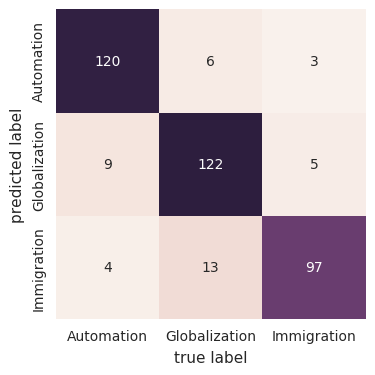

In [383]:
mat = confusion_matrix(test_target,labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Automation', 'Globalization', 'Immigration'],
                yticklabels=['Automation', 'Globalization', 'Immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [384]:
print('precision:', sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F-measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

precision: 0.895905882885
recall: 0.894459102902
F-measure: 0.894585556105


AUC of the ROC curve

In [385]:
# binarize
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
y_test = lb.transform(test_target)
y_score = clf.predict_proba(TFVects_test)

# Compute ROC curve and ROC area for each class
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])
print('auc:', roc_auc["macro"])

auc: 0.975545130802


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [386]:
clf = MLPClassifier()
clf

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [387]:
clf.fit(TFVects, train_target)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [388]:
clf.classes_

array(['automation', 'globalization', 'immigration'], 
      dtype='<U13')

In [389]:
print(clf.predict_proba(TFVects_test[82]))
print(clf.predict(TFVects_test[82]))
print(test_target[82])

[[  9.99482337e-01   4.04824504e-04   1.12838490e-04]]
['automation']
automation


In [390]:
labels = clf.predict(TFVects_test)

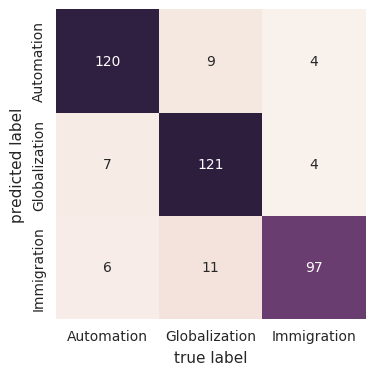

In [391]:
mat = confusion_matrix(test_target,labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Automation', 'Globalization', 'Immigration'],
                yticklabels=['Automation', 'Globalization', 'Immigration'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [392]:
print('precision:', sklearn.metrics.precision_score(test_target, labels, average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(test_target, labels, average = 'weighted')) #recall
print('F-measure:', sklearn.metrics.f1_score(test_target, labels, average = 'weighted')) #F-1 measure

precision: 0.893382863491
recall: 0.891820580475
F-measure: 0.891827729866


AUC of the ROC curve

In [393]:
# binarize
lb = preprocessing.LabelBinarizer()
lb.fit(test_target)
y_test = lb.transform(test_target)
y_score = clf.predict_proba(TFVects_test)

# Compute ROC curve and ROC area for each class
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])
print('auc:', roc_auc["macro"])

auc: 0.976410687393


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# My Memo

Here I used the same corpus consisting of Guardian articles I collected using the following three keywords: 'automation', 'globalization', 'immigration'. The heatmaps suggest that both models are highly effective in classifiying the test set articles. Precision for the trained SVM classifier is 0.896 and precision for the neural network classifier is 0.890. Recall for the trained SVM classifier is 0.894 and recall for the neural network classifier is 0.889. F-measure for the trained SVM classifier is 0.895 and F-measure for the neural network classifier is 0.889. AUC for SVM is 0.9755 and AUC for the neural network classifier is 0.9764. These scores seem to suggest that the last two classifiers perform better than all other classifiers.